In [1]:
import sys
sys.path.append("./libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy

C:\Users\victo\AppData\Local\Temp\ipykernel_22392\3313560318.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Carga de datos

In [3]:
df = pd.read_csv('./data/PERU_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 1995-03-01 to 2023-10-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  344 non-null    float64
 1   PD37976BM  344 non-null    float64
 2   PN02028AM  344 non-null    float64
 3   PD37972BM  344 non-null    float64
 4   PD37974BM  344 non-null    float64
 5   Class      344 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.8 KB


In [5]:
df.describe()

,PN02312FM,PD37976BM,PN02028AM,PD37972BM,PD37974BM,Class
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.006540,0.003332,0.002009,0.005400,0.002996,0.145349
std,0.009723,0.008992,0.006924,0.007266,0.013820,0.352966
min,-0.023125,-0.021834,-0.024268,-0.014352,-0.044618,0.000000
25%,-0.000013,-0.001842,-0.001570,0.000846,-0.004068,0.000000
50%,0.007247,0.003954,0.002133,0.006201,0.003270,0.000000
75%,0.011854,0.009464,0.006366,0.009691,0.010595,0.000000
max,0.041441,0.026307,0.026851,0.025603,0.035129,1.000000


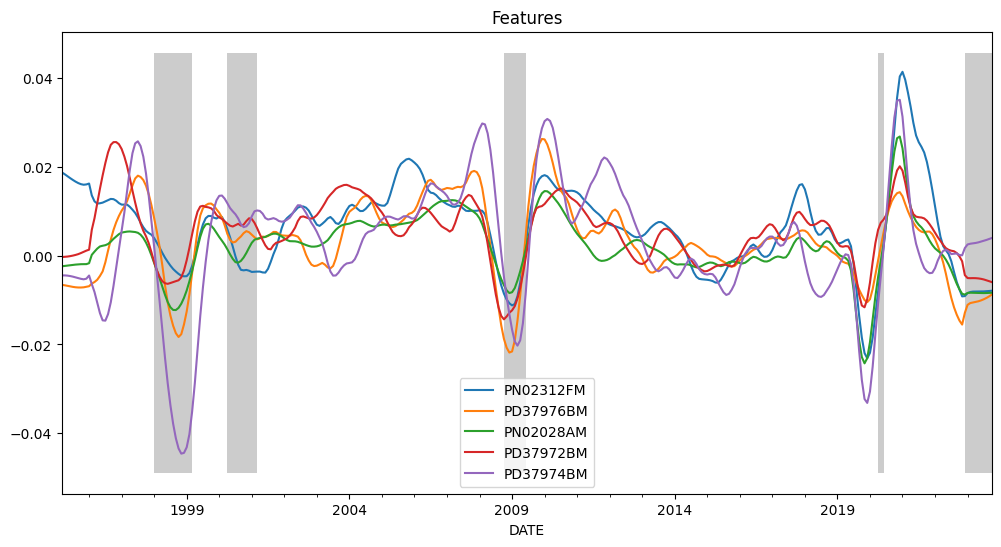

In [6]:
graficarTodo(df,'Features')

# Dividir Datos

In [7]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.3)

# Normalizar

In [8]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

In [9]:
n_features = len(features)

In [15]:
res_peru_1 = {
    'MLP_PERU':['./modelamiento/modelos/MLP_PERU_1_20240211_1522_3.h5',24],
    'CNN_PERU':['./modelamiento/modelos/CNN_PERU_1_20240211_1834_2.h5', 4],
    'LSTM_PERU':['./modelamiento/modelos/LSTM_PERU_1_20240222_2043_5.h5', 4],
    'GRU_PERU':['./modelamiento/modelos/GRU_PERU_1_20240211_2052_8.h5', 4],
    'MLP_PERU_FT':['./modelamiento/modelos/MLP_TL_PERU_1_20240211_1810_1.h5', 24],
    'CNN_PERU_FT':['./modelamiento/modelos/CNN_TL_PERU_1_20240211_1852_16.h5', 19],
    'LSTM_PERU_FT':['./modelamiento/modelos/LSTM_TL_PERU_1_20240222_2123_1.h5', 7],
    'GRU_PERU_FT':['./modelamiento/modelos/GRU_TL_PERU_1_20240211_2139_4.h5', 10],
}
res_peru_6 = {
    'MLP_PERU':['./modelamiento/modelos/MLP_PERU_6_20240211_1522_16.h5',12],
    'CNN_PERU':['./modelamiento/modelos/CNN_PERU_6_20240211_1834_7.h5', 4],
    'LSTM_PERU':['./modelamiento/modelos/LSTM_PERU_6_20240222_2043_8.h5', 8],
    'GRU_PERU':['./modelamiento/modelos/GRU_PERU_6_20240211_2052_4.h5', 9],
    'MLP_PERU_FT':['./modelamiento/modelos/MLP_TL_PERU_6_20240211_1810_13.h5', 7],
    'CNN_PERU_FT':['./modelamiento/modelos/CNN_TL_PERU_6_20240211_1852_18.h5', 14],
    'LSTM_PERU_FT':['./modelamiento/modelos/LSTM_TL_PERU_6_20240222_2123_9.h5', 5],
    'GRU_PERU_FT':['./modelamiento/modelos/GRU_TL_PERU_6_20240211_2139_16.h5', 6],
}
res_peru_12 = {
    'MLP_PERU':['./modelamiento/modelos/MLP_PERU_12_20240211_1522_4.h5',6],
    'CNN_PERU':['./modelamiento/modelos/CNN_PERU_12_20240211_1834_14.h5', 24],
    'LSTM_PERU':['./modelamiento/modelos/LSTM_PERU_12_20240222_2043_5.h5', 6],
    'GRU_PERU':['./modelamiento/modelos/GRU_PERU_12_20240211_2052_7.h5', 8],
    'MLP_PERU_FT':['./modelamiento/modelos/MLP_TL_PERU_12_20240211_1810_5.h5', 24],
    'CNN_PERU_FT':['./modelamiento/modelos/CNN_TL_PERU_12_20240211_1852_17.h5', 22],
    'LSTM_PERU_FT':['./modelamiento/modelos/LSTM_TL_PERU_12_20240222_2123_6.h5', 9],
    'GRU_PERU_FT':['./modelamiento/modelos/GRU_TL_PERU_12_20240211_2139_9.h5', 8],
}

# Evaluar

In [11]:
def predecir(models: dict, n_steps_out):
    df_res = df_y_test.copy()
    df_res = df_res.shift(-n_steps_out)
    df_val = pd.DataFrame()

    for key in models.keys():
        n_steps_in = models[key][1]
        model = load_model(models[key][0])
        #x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
        x_test, y_test, indexes = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
        y_pred = model(x_test)
        df = pd.DataFrame()
        df['DATE'] = indexes
        df['DATE'] = pd.to_datetime(df['DATE'])
        df[key] = y_pred
        df = df.set_index('DATE')
        df_res = pd.concat([df_res, df[key]], axis=1)
    
        res = model.evaluate(x_test, y_test, verbose=0)
        df_val_n = pd.DataFrame({
            'tp': [res[1]],
            'fp': [res[2]],
            'tn': [res[3]],
            'fn': [res[4]],
            'accuracy': [res[5]],
            'precision': [res[6]],
            'recall': [res[7]],
            'auc': [res[8]],
            'prc': [res[9]],
        }, index = [key])
        df_val = pd.concat([df_val, df_val_n])

    return df_res, df_val

In [12]:
df_1, df_1_val = predecir(res_peru_1,1)
#graficarTodo(df_1,"Predicción de Recesión con 1 mes de anticipación")
df_1_val

g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_PERU,3.0,11.0,54.0,11.0,0.721519,0.214286,0.214286,0.717582,0.313917
CNN_PERU,2.0,6.0,79.0,12.0,0.818182,0.250000,0.142857,0.931933,0.488495
LSTM_PERU,14.0,27.0,58.0,0.0,0.727273,0.341463,1.000000,0.928992,0.480800
GRU_PERU,14.0,55.0,30.0,0.0,0.444444,0.202899,1.000000,0.943698,0.537187
MLP_PERU_FT,13.0,22.0,43.0,1.0,0.708861,0.371429,0.928571,0.857692,0.415331
CNN_PERU_FT,14.0,48.0,22.0,0.0,0.428571,0.225806,1.000000,0.908674,0.523195
LSTM_PERU_FT,14.0,42.0,40.0,0.0,0.562500,0.250000,1.000000,0.959495,0.682549
GRU_PERU_FT,14.0,33.0,46.0,0.0,0.645161,0.297872,1.000000,0.914105,0.459682


In [13]:
df_6, df_6_val = predecir(res_peru_6,6)
#graficarTodo(df_6,"Predicción de Recesión con 6 meses de anticipación")
df_6_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_PERU,4.0,5.0,67.0,10.0,0.825581,0.444444,0.285714,0.557540,0.397983
CNN_PERU,14.0,53.0,27.0,0.0,0.436170,0.208955,1.000000,0.775446,0.446032
LSTM_PERU,3.0,4.0,72.0,11.0,0.833333,0.428571,0.214286,0.846804,0.408302
GRU_PERU,8.0,11.0,64.0,6.0,0.808989,0.421053,0.571429,0.890952,0.516405
MLP_PERU_FT,10.0,10.0,67.0,4.0,0.846154,0.500000,0.714286,0.905380,0.570702
CNN_PERU_FT,10.0,25.0,45.0,4.0,0.654762,0.285714,0.714286,0.770408,0.587875
LSTM_PERU_FT,9.0,13.0,66.0,5.0,0.806452,0.409091,0.642857,0.839512,0.398451
GRU_PERU_FT,14.0,42.0,36.0,0.0,0.543478,0.250000,1.000000,0.931777,0.610953


In [16]:
df_12, df_12_val = predecir(res_peru_12,12)
#graficarTodo(df_12,"Predicción de Recesión con 6 meses de anticipación")
df_12_val

g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_PERU,0.0,16.0,56.0,14.0,0.651163,0.00,0.000000,0.106151,0.092026
CNN_PERU,0.0,0.0,54.0,14.0,0.794118,0.00,0.000000,0.687169,0.348153
LSTM_PERU,0.0,0.0,72.0,14.0,0.837209,0.00,0.000000,0.401290,0.125696
GRU_PERU,0.0,0.0,70.0,14.0,0.833333,0.00,0.000000,0.296429,0.111349
MLP_PERU_FT,1.0,3.0,51.0,13.0,0.764706,0.25,0.071429,0.494709,0.215391
CNN_PERU_FT,14.0,56.0,0.0,0.0,0.200000,0.20,1.000000,0.651148,0.247385
LSTM_PERU_FT,0.0,8.0,61.0,14.0,0.734940,0.00,0.000000,0.643375,0.213104
GRU_PERU_FT,0.0,18.0,52.0,14.0,0.619048,0.00,0.000000,0.153571,0.100547
